<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Rename 'pre-war' column to python friendly 'pre_war'
# This way, we can use df.pre_war to refer to the column.
df = df.rename(columns={'pre-war':'pre_war'})

df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre_war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# The 'created' feature is of type Object
df.created.dtype

dtype('O')

In [4]:
# Converting 'created' to datetime
df.created = df.created.astype('datetime64[ns]')
df.shape

(48817, 34)

In [5]:
df[df.created < 'April 2016'].shape

(0, 34)

In [6]:
df[(df.created >= 'April 2016') & (df.created < 'June 2016')].shape

(31844, 34)

In [7]:
df[df.created >= 'June 2016'].shape

(16973, 34)

In [8]:
df[df.created >= 'July 2016'].shape

(0, 34)

In [9]:
# Creating new attribute 'total_rooms' as sum of 'bathrooms' 
# and 'bedrooms'
df['total_rooms'] = df.bedrooms + df.bathrooms
df.total_rooms.value_counts()

2.0     15286
3.0     11083
1.0      9200
4.0      6940
5.0      3160
6.0      1605
4.5       291
7.0       277
3.5       210
5.5       190
2.5       154
0.0       151
8.0        83
6.5        67
9.0        49
7.5        32
10.0       16
8.5        11
1.5         9
12.0        2
11.0        1
Name: total_rooms, dtype: int64

In [10]:
# Going to use dislay_address to derive new attribute
# It hass 133 NaN entries that need to be fixed
display(df.isna().sum()['display_address'])

display(df.display_address.iloc[240])
print('\n')
# Fix display_address by removing door number from street_address
# If street address is not a valid string, set display_address to
# empty string.
fix_disp = lambda x: '' if (isinstance(x,float)) else ' '.join(x.split()[1:]) 

df.display_address.loc[df.display_address.isna()] = df.street_address[df.display_address.isna()].apply(fix_disp)

display(df.isna().sum()['display_address'])
display(df.display_address.iloc[240])



133

nan

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0

'Madison Avenue'

In [11]:
disp_addr = df.display_address.value_counts()
ldisp_addr = len(disp_addr)

freq = lambda x: disp_addr[x]

# Create new feature 'availabilty' by using the freq
# with which a specific display_address occurrs in
# the dataframe.
df['availability'] = df.display_address.apply(freq)

df.availability.value_counts()

1     5531
2     1948
3     1317
4     1080
5     1000
      ... 
82      82
80      80
73      73
57      57
53      53
Name: availability, Length: 146, dtype: int64

In [12]:
# Create 'yuppy' attribute by determining if a 
# specific entry offers both a fitness_centre and
# high_speed_internet
df['yuppy'] = df.fitness_center & df.high_speed_internet
df.yuppy.value_counts()

0    45354
1     3463
Name: yuppy, dtype: int64

In [13]:
# Extract columns with numerical values
num_df = df.select_dtypes(include=np.number)
num_df.head()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre_war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,availability,yuppy
0,1.5,3,40.7145,-73.9425,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,22,0
1,1.0,2,40.7947,-73.9667,5465,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,177,0
2,1.0,1,40.7388,-74.0018,2850,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,69,0
3,1.0,1,40.7539,-73.9677,3275,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,72,0
4,1.0,4,40.8241,-73.9493,3350,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,5,0


In [14]:
# The train dataset is created from the entries created in the
# months of April and May
df_train = df[(df.created >= 'April 2016') & (df.created < 'June 2016')]
df_train.shape

(31844, 37)

In [15]:
# The test dataset is created from the entries created in June
df_test = df[df.created >= 'June 2016']
df_test.shape

(16973, 37)

In [16]:
def display_corr(df, ax):
  '''

  Compute the Correlation matrix and display as a Seaborn heatmap

  Arguments:
  df - The dataframe for which the corr matrix needs to be computed and
       displayed.
  ax - The axes in which the heatmap is to be displayed.
  '''
  df_corr = df.corr()

# Generate a mask for the upper triangle (taken from seaborn example gallery)
  mask = np.zeros_like(df_corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

## heatmeap to see the correlation between features. 
  sns.heatmap(df_corr, 
              annot=False,
              mask = mask,
              cmap = 'RdBu_r',
              linewidths=0.1, 
              linecolor='white',
              vmax = .9,
              ax = ax,
              square=True)
  
  ax.set_title(f'Correlations Heat Map', y = 1.03,fontsize = 20);

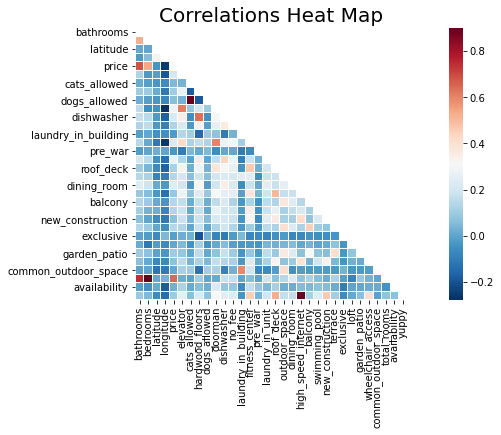

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,5))
#Compute and display the correlation coeff matrix
#for the numerical attributes
display_corr(num_df, ax)

In [18]:
# Define list of features that are highly correlated with price
high_corr = ['bathrooms', 'longitude']
# Define list of features that have a high medium correlation with price
hmed_corr = ['total_rooms']
# Define list of features that have a low medium correlation with price
lmed_corr = ['bedrooms','latitude','pre_war','laundry_in_building']


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Given the actual(y) and predicted(yp) target value, compute and return the
# MAE, RMSE and R2 measures.
get_errors = lambda y,yp: (mean_absolute_error(y,yp), np.sqrt(mean_squared_error(y,yp)), r2_score(y,yp))

#Let's try some linear regression
def linear_regression(df, corr_list, target='price'):
  '''

  Fit and return Linear Regression Model using the features
  and target provided.

  Arguments:
  df        - DataFrame with the features and target columns
  corr_list - List of predictive attributes
  target    - name of target column 
  '''

  # Extract the predictive attributes matrix X
  X = df[corr_list]

  # Extract the  target vector y
  y = df[target] 
  lr = LinearRegression()
  # Fit a model using X and y
  lr.fit(X,y)

  return lr

In [20]:
# Translate a baseline scalar into a vector
baseline_vector = lambda df,bl: [bl] * df.shape[0]

# Compute a baseline MAE.
def get_baseline_mae(df, bl, target='price'):

  '''

  Compute and return the MAE for the baseline.
  Arguments:
  df        - DataFrame with the features and target columns
  bl        - Scalar basline value
  target    - name of target column
  '''
  yp = baseline_vector(df, bl)
  mae = mean_absolute_error(df[target], yp)
  return mae

# Compute the MAE for both mean and median baselines
# Return a tuple with the name of baseline(mean/median),
# MAE and baseline for the one with the lower MAE.
def get_best_baseline(df, target='price'):
  bls = [('mean', df[target].mean()), ('median', df[target].median())]

  mae = (bls[0][0], get_baseline_mae(df, bls[0][1], target))
  for bl in bls[1:]:
    mae_ = get_baseline_mae(df, bl[1],target)
    if mae_ < mae[1]:
      mae = (bl[0], mae_, bl[1])

  return mae

In [21]:
def train_and_test_errors(df_train, df_test,corr_list=None, lr = None,bl=None, target='price'):

  '''

  Given the train and test datasets, compute and return the error measures for
  both datasets.
  Arguments:
  df_train  - Training dataset
  df_test   - Test dataset
  corr_list - List of feature columns, not required of lr is None
  lr        - Linear Regression model to be used to compute
              predicted(yp) target values
  bl        - Scalar baseline value
  target    - name of target column 
  '''
  if lr is not None:
    Xtrain = df_train[corr_list]
    Xtest = df_test[corr_list]
    yp_train = lr.predict(Xtrain)
    yp_test = lr.predict(Xtest)
  elif bl is not None:
    yp_train = baseline_vector(df_train, bl)
    yp_test = baseline_vector(df_test, bl)

  y_train = df_train[target]
  y_test = df_test[target]

  train_errors = get_errors(y_train, yp_train)
  test_errors = get_errors(y_test, yp_test)

  return train_errors, test_errors

In [22]:
def display_title(title):
  print(f'\n{title}')
  print('-'*len(title))

def display_errors(errors,s='Train'):
  hstr = f'{s} Errors'
  display_title(hstr)

  print(f'MAE  = {errors[0]:4.2f}')
  print(f'RMSE = {errors[1]:4.2f}')
  print(f'R2   = {errors[2]:4.2f}')

def display_train_test_errors(errors, title='The Train and Test error measures', title_sfx='for the Best Fit Model'):
  title = f'{title} {title_sfx}'
  display_title(title)

  elist = ['Train', 'Test']

  for idx,e in enumerate(elist):
    display_errors(errors[idx], e)

In [23]:
def display_model_parameters(lr):
  display_title('Linear Regression Model Parameters')

  print(f'Intercept = {lr.intercept_}')
  print(f'Coeffs.   = {lr.coef_}')

In [24]:
# get the baseline with the lowest MAE
bl_train = get_best_baseline(df_train)

print(f'The baseline MAE is {bl_train}')
# List of  feature sets - entries after 'baseline'
corrs = ['baseline', ['bathrooms'],['bedrooms'], ['total_rooms'], high_corr, hmed_corr, high_corr+hmed_corr, lmed_corr, high_corr+hmed_corr+lmed_corr]

# Set the best model errore to the one for the baseline
errors_best_model = (0, train_and_test_errors(df_train, df_test, bl=bl_train[2]), bl_train[0])

# Loop through the list of feature sets.
for idx,corr in enumerate(corrs[1:]):
  # For each predictive attribute set
  # compute the Linear Regression Model
  lr = linear_regression(df_train, corr)
  errors = train_and_test_errors(df_train, df_test, corr, lr)
  print(f'{corr} :: Test MAE = {errors[1][0]:4.2f}\n')
  #If the new MAE is lower than the previous best
  if errors[1][0] < errors_best_model[1][1][0]:
    # Store the new MAE as the best one
    # Store the feature set index, the new errors and 
    # Linear regression model
    errors_best_model = (idx+1, errors, lr) 
  

The baseline MAE is ('median', 1138.5192186911192, 3150.0)
['bathrooms'] :: Test MAE = 890.46

['bedrooms'] :: Test MAE = 988.73

['total_rooms'] :: Test MAE = 910.51

['bathrooms', 'longitude'] :: Test MAE = 821.60

['total_rooms'] :: Test MAE = 910.51

['bathrooms', 'longitude', 'total_rooms'] :: Test MAE = 743.53

['bedrooms', 'latitude', 'pre_war', 'laundry_in_building'] :: Test MAE = 981.28

['bathrooms', 'longitude', 'total_rooms', 'bedrooms', 'latitude', 'pre_war', 'laundry_in_building'] :: Test MAE = 744.24



In [25]:
print(f'The best regression model has a Test MAE of {errors_best_model[1][1][0]} and uses {corrs[errors_best_model[0]]}')

display_train_test_errors(errors_best_model[1])

display_model_parameters(errors_best_model[2])


The best regression model has a Test MAE of 743.5252434701682 and uses ['bathrooms', 'longitude', 'total_rooms']

The Train and Test error measures for the Best Fit Model
--------------------------------------------------------

Train Errors
------------
MAE  = 737.42
RMSE = 1148.19
R2   = 0.58

Test Errors
-----------
MAE  = 743.53
RMSE = 1134.19
R2   = 0.59

Linear Regression Model Parameters
----------------------------------
Intercept = -1146190.1255217488
Coeffs.   = [  1582.130556   -15501.58414297    426.28859762]
